In [1]:
scriptdirectory = r"C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Tübingen_Branch"

output_directory = r"D:\MEA_DATA_Aachen\ANALYZED\ID046_analysiert_22102021\analysis_26102021"
filename = "2021-05-17_cortex_div11_aCSF_ID046_30µMNorepinephrine_spont_1"

temp_dir = r"D:\MEA_DATA_Aachen\ANALYZED\ID046_analysiert_22102021\2021-05-17_cortex_div11_aCSF_ID046_30µMNorepinephrine_spont_1_from_0_to_120_analyzed_on_26102021"

In [78]:
import os
os.chdir(scriptdirectory)

In [79]:
import sys
import numpy as np
import pandas as pd
import importlib

import McsPy
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.signal import butter, lfilter, freqz, find_peaks, correlate, gaussian, filtfilt
from scipy import stats
from scipy import signal

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from Butterworth_Filter import butter_bandpass, butter_bandpass_filter

import glob
from plot_signal_and_spikes import plot_signal_and_spikes_from_bandpassfilteredsignal
import time

from neo.core import AnalogSignal
import quantities as pq

from elephant.spectral import welch_psd
from elephant.current_source_density import estimate_csd
import pickle

%matplotlib notebook

In [80]:
os.chdir(output_directory)

In [81]:
MAIN_RECORDING_DICTIONARY = pickle.load(open(os.path.join(output_directory+'\\MAIN_RECORDING_Dictionary_'+filename+'.pkl'), "rb"))

In [82]:
MAIN_RECORDING_DICTIONARY.keys()

dict_keys(['spikedic_MAD', 'network_bursts_seconds', 'fr_dic', 'isi_dictionary', 'isi_average_dic', 'isi_std_dic', 'Infos_Recording', 'Infos_Analysis', 'Infos_Anatomy', 'Basics', 'Bursts', 'Interburst-Intervals', 'bursting_time_per_channel', 'bursts_per_channel', 'burst_connections', 'GRAPH_shared_bursts'])

In [83]:
network_bursts_seconds = MAIN_RECORDING_DICTIONARY['network_bursts_seconds']
spikedic_MAD = MAIN_RECORDING_DICTIONARY['spikedic_MAD']
fr_dic = MAIN_RECORDING_DICTIONARY['fr_dic']
isi_dictionary = MAIN_RECORDING_DICTIONARY['isi_dictionary']
isi_average_dic = MAIN_RECORDING_DICTIONARY['isi_average_dic']
Infos_Recording = MAIN_RECORDING_DICTIONARY['Infos_Recording']
Infos_Analysis = MAIN_RECORDING_DICTIONARY['Infos_Analysis']
Infos_Anatomy = MAIN_RECORDING_DICTIONARY['Infos_Anatomy']
Bursts = MAIN_RECORDING_DICTIONARY['Bursts']
Interburst_Intervals = MAIN_RECORDING_DICTIONARY['Interburst-Intervals']
bursting_time_per_channel = MAIN_RECORDING_DICTIONARY['bursting_time_per_channel']
bursts_per_channel = MAIN_RECORDING_DICTIONARY['bursts_per_channel']
burst_connections = MAIN_RECORDING_DICTIONARY['burst_connections']
Basics = MAIN_RECORDING_DICTIONARY['Basics']
inverted_layerdic = Infos_Anatomy['layerdic_invert']
layerdic = Infos_Anatomy['layerdic']
tick = 40
scale_factor_for_second = 1e-06

In [118]:
# ID034
layerdic = {'layer1':[], 

            'layer2-3': ['A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15',
                        'B16', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16',  'D11', 'D12', 'D13', 'D14', 'D15', 'D16',
                        'E12', 'E13', 'E14', 'E15', 'E16', 'F13', 'F14', 'F15', 'F16', 'G13', 'G14', 'G15', 'G16', 'H14',
                        'H15', 'H16', 'J15', 'J16', 'K16'],

           'layer4':    ['A8', 'B7', 'B8', 'C8', 'C9', 'D8', 'D9', 'D10', 'E9', 'E10', 'E11', 'F10', 'F11', 'F12',
                        'G11', 'G12', 'H12', 'H13', 'J12', 'J13', 'J14', 'K13', 'K14', 'K15', 'L14', 'L15', 'L16', 'M16',
                        'M16', 'N16'],


           'layer5-6':  ['B2', 'B3', 'B4', 'B5', 'B6', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7',
                        'D3', 'D4', 'D5', 'D6', 'D7', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9',
                        'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'J6', 'J7', 
                        'J8', 'J9', 'J10', 'J11',  'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'K12',  'L7', 'L8', 'L9', 'L10', 
                        'L11', 'L12', 'L13', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14',  'N8', 'N9', 'N10', 'N11', 
                        'N12', 'N13', 'N14', 'N15',  'O8', 'O9', 'O10', 'O11', 'O12', 'O13', 'O14', 'O15', 'O16', 
                        'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'R9', 'R10', 'R11', 'R12', 'R13', 
                        'R14', 'R15'
                        ],

           'whitematter':['B1', 'C1', 'D1', 'D2', 'E1', 'E2', 'F1', 'F2', 'F3', 'G1', 'G2', 'G3', 'G4', 'H1', 'H2', 'H3', 'H4',
                         'J1', 'J2', 'J3', 'J4', 'J5', 'K1', 'K2', 'K3', 'K4', 'K5', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L1', 
                         'L2', 'L3', 'L4', 'L5', 'L6', 'M7', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'O2', 'O3', 'O4', 'O5', 'O6', 
                         'O7',  'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8' ],

           'not_on_slice':['A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'N1', 'O1', 'P1']}


In [119]:
def invert_layerdic(layer_dic):
    
    '''
    Expects a dictionary with key = layer, value = list of channellabels
    
    Returns a dictionary with key = channellabels, value = layer
    '''
    layerdic_invert = {}

    for key in layerdic:
        for i in layerdic[key]:
            layerdic_invert[i]=key
            
            
    return layerdic_invert

In [120]:
inverted_layerdic = invert_layerdic(layerdic)

### Import of all Custom Functions

In [88]:

def get_channel_infos(filedirectory, meafile):
    channel_raw_data = McsPy.McsData.RawData(os.path.join(filedirectory, 
                                                          meafile))
    print(channel_raw_data.recordings)
    print(channel_raw_data.comment)
    print(channel_raw_data.date)
    print(channel_raw_data.clr_date)
    print(channel_raw_data.date_in_clr_ticks)
    print(channel_raw_data.file_guid)
    print(channel_raw_data.mea_name)
    print(channel_raw_data.mea_sn)
    print(channel_raw_data.mea_layout)
    print(channel_raw_data.program_name)
    print(channel_raw_data.program_version)
    analognumber = len(channel_raw_data.recordings[0].analog_streams.keys())
    print('In total '+ str(analognumber) 
          + " analog_streams were identified.\n")
    for i in range(len(channel_raw_data.recordings[0].analog_streams.keys())):
        keylist = []
        stream = channel_raw_data.recordings[0].analog_streams[i]
        for key in stream.channel_infos.keys():
                keylist.append(key)
        channel_id = keylist[0]
        datapoints = channel_raw_data.recordings[0].analog_streams[i].channel_data.shape[1]
        samplingfrequency = stream.channel_infos[channel_id].sampling_frequency
        ticks = stream.channel_infos[channel_id].info['Tick']
        time = stream.get_channel_sample_timestamps(channel_id)
        scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
        time_in_sec = time[0] * scale_factor_for_second
        timelengthrecording_ms = time[0][-1]+ticks
        timelengthrecording_s = (time[0][-1]+ticks)*scale_factor_for_second
        print("analog_stream Nr. " + str(i) + ": ")
        print("datapoints measured = " + str(datapoints))
        print("sampling frequency = " + str(samplingfrequency))
        print("ticks = " + str(ticks))
        print("total recordingtime is: " 
              + str(timelengthrecording_s) + "seconds \n")




def get_MEA_Signal(analog_stream, channel_idx, from_in_s=0, to_in_s=None):
    '''
    Extracts one Channels (channel_idx) Sginal 
    
    :param analog_stream = the analogstream from one recording
    :param channel_idx   = the channel index of the channel where you 
                            extract the values from
    :param from_in_s     = starting point of the range you want to observe 
                            in seconds
    :param to_in_s       = ending point of the range you want to observe. 
                            Default is None (i.e. whole range)
    
    Returns: the signal in uV, time stamps in sec, the sampling frequency
    
    
    '''
    ids = [c.channel_id for c in analog_stream.channel_infos.values()]
    channel_id = ids[channel_idx]
    channel_info = analog_stream.channel_infos[channel_id]
    sampling_frequency = channel_info.sampling_frequency.magnitude

    # get start and end index
    from_idx = max(0, int(from_in_s * sampling_frequency))
    if to_in_s is None:
        to_idx = analog_stream.channel_data.shape[1]
    else:
        to_idx = min(
            analog_stream.channel_data.shape[1], 
            int(to_in_s * sampling_frequency)
            )

    # get the timestamps for each sample
    time = analog_stream.get_channel_sample_timestamps(
        channel_id, from_idx, to_idx
        )

    # scale time to seconds:
    scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
    time_in_sec = time[0] * scale_factor_for_second

    # get the signal
    signal = analog_stream.get_channel_in_range(channel_id, from_idx, to_idx)

    # scale signal to µV:
    scale_factor_for_uV = Q_(1,signal[1]).to(ureg.uV).magnitude
    signal_in_uV = signal[0] * scale_factor_for_uV
    
    return signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second


def get_MEA_Channel_labels(np_analog_for_filter):
    '''
    Gives a List of all MEA Channel Labels (e.g. R12) in the order they appear
    within the recording.
    
    :param analogstream_data = an numpy array shape(channels, data)
    
    '''
    labellist = []
    for i in range(0, len(np_analog_for_filter)):
        #channel_idx = i
        ids = [c.channel_id for c in analog_stream_0.channel_infos.values()]
        channel_id = ids[i]
        channel_info = analog_stream_0.channel_infos[channel_id]
        #print(channel_info.info['Label'])
        labellist.append(channel_info.info['Label'])
    return labellist
    

def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return 
    them as an array

    The signal transitions from a sample above the threshold to a sample 
    below the threshold for a detection and
    the last detection has to be more than dead_time apart 
    from the current one.

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold: The threshold for the signal
    :param dead_time: The dead time in seconds.
    """
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff(
        (signal <= threshold).astype(int) > 0).nonzero()[0]
    distance_sufficient = np.insert(
        np.diff(threshold_crossings) >= dead_time_idx, 0, True
        )
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(
            np.diff(threshold_crossings) >= dead_time_idx, 0, True
            )
    return threshold_crossings


def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index

    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index
    :param max_samples_to_search: The number of samples to search for a 
                                    minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx


def align_to_minimum(signal, fs, threshold_crossings, search_range, first_time_stamp=0):
    """
    Returns the index of the next negative spike peak for all threshold crossings

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold_crossings: The array of indices where the signal 
                                crossed the detection threshold
    :param search_range: The maximum duration in seconds to search for the 
                         minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)


def find_triggers(dset_trigger, tick):
    
    for i in range(0,len(dset_trigger)-1):
        trigger_n=i
        Trigger_An=dset_trigger[trigger_n]
        diff_An=np.diff(Trigger_An)
        peaks, _ = find_peaks(diff_An, height = 2000) #MEA60=0.75
        peaks_off, _ = find_peaks(-diff_An, height = 2000) #""
        if len(peaks)>=0:
            break
    
    if trigger_n ==0:
        odd_peaks= peaks
        odd_peaks_off= peaks_off
    else:
        odd_peaks=peaks
        odd_peaks_off=peaks_off
    #x=np.arange(len(Trigger_An))*tick
    #plt.plot(x, Trigger_An)
    return odd_peaks, odd_peaks_off, diff_An

def spike_on_off(trigger_on, trigger_off, spikedic, tick):
    """
    Takes the dictionary with all spikes and sorts them into either a dictionary for
    spikes while trigger on (=ONdic) or off (=OFFdic)
    
    :param trigger_on =basically created through the find_triggers function 
                        and marks points were stimulation is turned on
    :param trigger_off =see trigger_on but for stimulation off
    :spikedic = dictionary of spikes for each electrode
    :tick
    """
    on=[]
    off=[]
    ONdic ={}
    OFFdic={}
    Trigger_An=[]
    Trigger_Aus=[]
    
    if len(trigger_off)==0:
        Trigger_An=[]
    elif trigger_off[len(trigger_off)-1]>trigger_on[len(trigger_on)-1]:
        Trigger_An=trigger_on*tick
    else:
        Trigger_An=[]
        for n in range(0,len(trigger_on)-1):
            Trigger_An.append(trigger_on[n]*tick)   
        Trigger_An=np.array(Trigger_An)

            
    if len(trigger_on)==0:
        Trigger_Aus=[]
    elif trigger_off[0]>trigger_on[0]:
        Trigger_Aus=trigger_off*tick
    else:
        Trigger_Aus=[]
        for n in range(1,len(trigger_off)):
            Trigger_Aus.append(trigger_off[n]*tick)
        Trigger_Aus=np.array(Trigger_Aus)
    
    Trigger_Aus2=np.insert(Trigger_Aus,0,0)
    
    for key in spikedic:
        ON = []
        OFF = []
        for i in spikedic[key]: #i mit 40 multiplizieren, da Trigger an und aus mit Tick multipliziert sind
            if len(Trigger_An)==0:
                OFF.append(i)
            if any(Trigger_An[foo] < i*tick < Trigger_Aus[foo]  for foo in np.arange(len(Trigger_Aus)-1)):
                ON.append(i)
            elif any(Trigger_Aus2[foo]  < i*tick < Trigger_An[foo]  for foo in np.arange(len(Trigger_An))):
                OFF.append(i)
        ONdic[key]=np.asarray(ON)
        OFFdic[key]=np.asarray(OFF)
    
    return ONdic, OFFdic


def extract_waveforms(signal, fs, spikes_idx, pre, post):
    """
    Extract spike waveforms as signal cutouts around each spike index as a spikes x samples numpy array

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param spikes_idx: The sample index of all spikes as a 1-dim numpy array
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    """
    cutouts = []
    pre_idx = int(pre * fs)
    post_idx = int(post * fs)
    for index in spikes_idx:
        if index-pre_idx >= 0 and index+post_idx <= signal.shape[0]:
            cutout = signal[int((index-pre_idx)):int((index+post_idx))]
            cutouts.append(cutout)
    if len(cutouts)>0:
        return np.stack(cutouts)
    
    
def plot_waveforms(cutouts, fs, pre, post, n=100, color='k', show=True):
    """
    Plot an overlay of spike cutouts

    :param cutouts: A spikes x samples array of cutouts
    :param fs: The sampling frequency in Hz
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    :param n: The number of cutouts to plot, or None to plot all. Default: 100
    :param color: The line color as a pyplot line/marker style. Default: 'k'=black
    :param show: Set this to False to disable showing the plot. Default: True
    """
    if n is None:
        n = cutouts.shape[0]
    n = min(n, cutouts.shape[0])
    time_in_us = np.arange(-pre*1000, post*1000, 1e3/fs)
    if show:
        _ = plt.figure(figsize=(12,6))

    for i in range(n):
        _ = plt.plot(time_in_us, cutouts[i,]*1e6, color, linewidth=1, alpha=0.3)
        _ = plt.xlabel('Time (%s)' % ureg.ms)
        _ = plt.ylabel('Voltage (%s)' % ureg.uV)
        _ = plt.title('Cutouts')

    if show:
        plt.show()

        
def butter_lowpass_filter(data, cutoff, fs, order):

    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y



def subdivide_spiketrain(spiketrain, sub_start = 0, sub_stop = 10, tick=40, scale_factor_for_second=1e-06):
    '''
    Excpects: 
        a spiketrain with tick datapoints
        default ticks are 40
        default scale_factor_for_seconds = 1e-06
        provide the start and stop of the desired sub in seconds
    
    Does:
        converts the desired seconds into data ticks
        checks if the spikes of the given spiketrain is in the desired subs
        substracts the starting time -->
        
    Returns:
        a spiketrain dictionary that again starts from zero
    
    '''
    sub_start_tick = sub_start / (tick*scale_factor_for_second)
    sub_stop_tick = sub_stop / (tick*scale_factor_for_second)
    sub_spiketrain = {}
  
    for key in spiketrain: 
        list_per_key = []
        for i in spiketrain[key]:
            if (i>=sub_start_tick ) & (i<sub_stop_tick):
                list_per_key.append(int(i-sub_start_tick))
        sub_spiketrain[key]=list_per_key

    return sub_spiketrain

### Find channels that are bursting during network bursts


In [89]:
Bursts['R12'] #µseconds

[]

In [90]:
spikedic_MAD['R12'][-1] #ticks

2974791

In [91]:
network_bursts_seconds[-1] #seconds

(114.41099635215947, 116.35166267774086)

In [92]:
tick = 40

In [93]:
length = []

for i in network_bursts_seconds:
    diff = i[1] - i[0]
    length.append(diff)

In [94]:
np.max(length)

3.173385496677753

In [95]:
len(network_bursts_seconds)

29

In [96]:
np.mean(length), np.std(length), np.median(length)

(1.9395740186733876, 0.42798656792412326, 1.9258142873754167)

We want to find every channel that does burst during a network burst. Further, we need for every network burst the amount of active channels (via Spikedic_MAD). The LFP will be extracted in a later step. For this, we will need the raw data.

In [97]:
filename= '2021-05-17T11-28-41__cortex_div11_aCSF_ID046_30µMNorepinephrine_spont_1'

In [98]:
filebase = filename.split('__')[1]

In [99]:
glob.glob('*lowpass*.npy')

[]

In [100]:
os.chdir(temp_dir)

In [101]:
temp_dir

'D:\\MEA_DATA_Aachen\\ANALYZED\\ID046_analysiert_22102021\\2021-05-17_cortex_div11_aCSF_ID046_30µMNorepinephrine_spont_1_from_0_to_120_analyzed_on_26102021'

In [102]:
lowpassfile = glob.glob('*lowpass*.npy')[0]
bandpassfile = glob.glob('*bandpass*.npy')[0]

lfp_down_file = glob.glob('*LFP_DOWNS*.npy')[1]
lfp_up_file = glob.glob('*LFP_UPS*.npy')[1]

lfp_amp_down_file = glob.glob('*LFP_Amplitudes_DOWNS*.npy')[0]
lfp_amp_up_file = glob.glob('*LFP_Amplitudes_UPS*.npy')[0]

cs_lfp_down_file = glob.glob('*cs_lfp_down*.npy')[0]
cs_lfp_up_file = glob.glob('*cs_lfp_up*.npy')[0]

cs_lfp_amp_down_file = glob.glob('*cs_lfp_amp*down*.npy')[0]
cs_lfp_amp_up_file = glob.glob('*cs_lfp_amp*up*.npy')[0]

In [24]:
lfp_down_file


'2021-05-17_cortex_div11_aCSF_ID046_30µMNorepinephrine_spont_1_0_120_LFP_DOWNS.npy'

In [25]:
# bandpass and lowpass signal
lowpass_dic = np.load(lowpassfile, allow_pickle=True).item()
bandpass_dic = np.load(bandpassfile, allow_pickle=True).item()

# lfp deviations
lfp_downs = np.load(lfp_down_file, allow_pickle=True).item()
lfp_ups = np.load(lfp_up_file, allow_pickle=True).item()

# lfp amplitudes
lfp_amplit_downs = np.load(lfp_amp_down_file, allow_pickle=True).item()
lfp_amplit_ups = np.load(lfp_amp_up_file, allow_pickle=True).item()



# cs lfp deviations
cs_lfp_downs = np.load(cs_lfp_down_file, allow_pickle=True).item()
cs_lfp_ups = np.load(cs_lfp_up_file, allow_pickle=True).item()

# cs lfp amplitudes
cs_lfp_amplit_downs = np.load(cs_lfp_amp_down_file, allow_pickle=True).item()
cs_lfp_amplit_ups = np.load(cs_lfp_amp_up_file, allow_pickle=True).item()

hier fehlen leider die neuen Dics, weil sie nicht gespeichert wurden

In [28]:
filename


'2021-05-17T11-28-41__cortex_div11_aCSF_ID046_30µMNorepinephrine_spont_1'

In [29]:
start, stop = 0, 120

In [30]:
channel_look = 'F15'

In [31]:
second_cut = lowpass_dic[channel_look].shape[0]

In [32]:
lowpass_sig = lowpass_dic[channel_look]
bandpass_sig = bandpass_dic[channel_look]
down_cross = lfp_downs[channel_look]
up_cross = lfp_ups[channel_look]
spikes = spikedic_MAD[channel_look]
channel_bursts = Bursts[channel_look]

cs_down_cross = cs_lfp_downs[channel_look]
cs_up_cross = cs_lfp_ups[channel_look]

In [33]:
up_cross

[(90.4776, 90.77992), (106.71768, 107.01487999999999)]

In [34]:
# scale helper functions to get the right unit
scale_to_sec = lambda x: x*tick*scale_factor_for_second
scaleburst_to_sec = lambda x: x*scale_factor_for_second
scale_to_ticks = lambda x: x/ (tick*scale_factor_for_second)

In [35]:
spikes = list(map(scale_to_sec, spikes))

# cut spikes for the observed part
spikes = [x for x in spikes if start <= x <= stop]

In [36]:
channel_bursts

[(90331760, 90410520),
 (90496440, 90672160),
 (106589400, 106933200),
 (113360600, 113370600)]

In [37]:
#channel_bursts = list(map(scale_to_sec, channel_bursts))
channel_bursts_sec = []
for i in channel_bursts:
    first = scaleburst_to_sec(i[0])
    second = scaleburst_to_sec(i[1])
    new = (first, second)
    channel_bursts_sec.append(new)

In [120]:
channel_bursts_sec

[(90.33176, 90.41051999999999),
 (90.49643999999999, 90.67215999999999),
 (106.5894, 106.9332),
 (113.36059999999999, 113.3706)]

In [121]:
# to cut the low pass signal
networkburst_tick = list(map(scale_to_ticks, network_bursts_seconds[0]))
networkburst_tick_start, netwokrburst_tick_stop = int(networkburst_tick[0]), int(networkburst_tick[1])

In [46]:
# cut the low pass signal
network_burst_lowpass_cut = lowpass_sig[networkburst_tick_start:netwokrburst_tick_stop]

In [47]:
# to cut the bursts and networkbursts

cut_network_bursts_seconds = list(filter(lambda x: start < x[0] < stop, network_bursts_seconds))
cut_channel_bursts_seconds = list(filter(lambda x: start < x[0] < stop, channel_bursts_sec))

In [48]:

for networkburst in network_bursts_seconds:
    networkburst_tick = list(map(scale_to_ticks, networkburst))
    networkburst_tick_start, netwokrburst_tick_stop = int(networkburst_tick[0]), int(networkburst_tick[1])
    network_burst_lowpass_cut = lowpass_sig[networkburst_tick_start:netwokrburst_tick_stop]
                             
    mean_lowpass_cut = np.mean(network_burst_lowpass_cut)
    std_lowpass_cut = np.std(network_burst_lowpass_cut)
    
    print('Channel {}, at {}, mean: {} with std {}'.format(
        channel_look, networkburst, mean_lowpass_cut, std_lowpass_cut ))

mean_channel = np.mean(lowpass_sig)
std_channel = np.std(lowpass_sig)
print('Channel {} total, mean: {} with std {}'.format(
        channel_look, mean_channel, std_channel))
    

Channel F15, at (0.7632, 1.7830399568106312), mean: -0.16937125608042608 with std 2.8111601907655848
Channel F15, at (4.198971504983389, 5.520802905315615), mean: -0.5933934091996161 with std 3.0733813666521717
Channel F15, at (7.510976024916944, 9.134798868770764), mean: -0.36977167438955577 with std 3.0099683525861223
Channel F15, at (11.694300119601328, 13.664670521594685), mean: 0.05298240131281912 with std 2.572275636541489
Channel F15, at (16.12020750498339, 18.02621907475083), mean: -0.2653725870704486 with std 2.6911630870660685
Channel F15, at (19.486669498338873, 21.437237182724253), mean: 0.2959285544691534 with std 2.647550087563668
Channel F15, at (23.249185843853823, 25.160148093023256), mean: -0.282151772847112 with std 2.988297562010397
Channel F15, at (26.87308316611296, 28.784045415282392), mean: 0.1674191102723491 with std 2.617286849889964
Channel F15, at (31.393053460132894, 33.28916367109635), mean: 0.4258209700629328 with std 3.282520433731624
Channel F15, at (36

In [49]:
len(lowpass_sig)

3000001

In [50]:
tick_micro = 0.00004
time_in_sec = np.arange(start, stop+tick_micro, tick_micro)

In [51]:
len(time_in_sec)

3000001

In [52]:
network_bursts_seconds

[(0.7632, 1.7830399568106312),
 (4.198971504983389, 5.520802905315615),
 (7.510976024916944, 9.134798868770764),
 (11.694300119601328, 13.664670521594685),
 (16.12020750498339, 18.02621907475083),
 (19.486669498338873, 21.437237182724253),
 (23.249185843853823, 25.160148093023256),
 (26.87308316611296, 28.784045415282392),
 (31.393053460132894, 33.28916367109635),
 (36.24966995348837, 37.63487377408637),
 (37.734873774086374, 39.591378549833884),
 (42.190485235880395, 44.18560903488372),
 (46.824321156146176, 48.75013544352159),
 (51.03239864784053, 53.00276904983389),
 (55.418700598006644, 57.05737548006645),
 (58.81981734717608, 60.71592755813953),
 (61.562493735880395, 64.73587923255815),
 (68.08748918770765, 69.82022697840532),
 (72.03813135049833, 73.98374835548172),
 (75.47390285548173, 78.27103671760797),
 (80.8651927242525, 82.4246567358804),
 (88.6823155, 91.49430140033223),
 (94.13796420099668, 96.10338392358804),
 (98.40544984551495, 100.84613479069768),
 (103.85614786710964

In [53]:
channel_mean = np.mean(lowpass_sig)
print('Lowpass mean of {} at  {} is '.format(channel_look, networkburst)+str(channel_mean))

Lowpass mean of F15 at  (114.41099635215947, 116.35166267774086) is -0.03195077538345987


In [54]:
np.std(lowpass_sig)

7.8901941299268525

In [55]:
lfp_mean = np.mean(lowpass_sig)

In [56]:
lfp_threshold = 3*np.std(lowpass_sig)

In [57]:
time_in_sec.shape[0] * lfp_threshold

71011770.83992405

In [58]:
threshold_line = np.linspace(lfp_threshold, lfp_threshold, len(time_in_sec))

In [59]:
convolved_signal = np.convolve(lowpass_sig, np.ones(3000)/3000, mode='full')

In [60]:
len(convolved_signal)

3003000

In [61]:
cs = convolved_signal[:3000001]

In [62]:
cs_threshold_line = np.linspace(2*np.std(cs), 2*np.std(cs), len(time_in_sec))

In [63]:
len(time_in_sec)


3000001

<IPython.core.display.Javascript object>


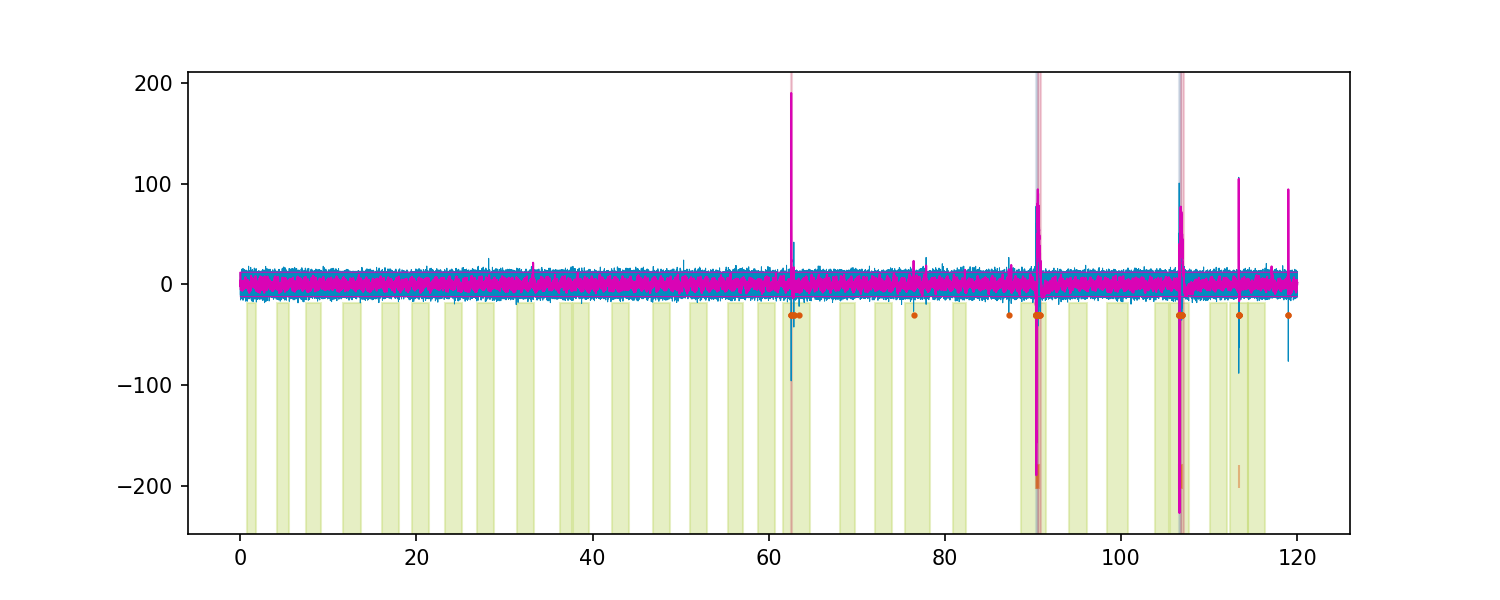

<ipython-input-64-d78263ff79cf>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(spikes, [-30]*np.asarray(spikes).shape[0], 'ro', ms=2, c="#D9580D")


In [64]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))


ax.plot(time_in_sec[:second_cut], bandpass_sig, c = '#048ABF',  linewidth = 0.5)
ax.plot(time_in_sec[:second_cut], lowpass_sig, c = '#D904B5',  linewidth = 1)
ax.plot(spikes, [-30]*np.asarray(spikes).shape[0], 'ro', ms=2, c="#D9580D")
ax.plot(time_in_sec, cs_threshold_line, c = '#D904B5', linewidth = 0.5 )
ax.plot(time_in_sec, -cs_threshold_line, c = '#D904B5', linewidth = 0.5 )
#ax.plot(time_in_sec, -threshold_line, c = '#D904B5', linewidth = 0.5 )
#ax.plot(time_in_sec, cs, c = '#263140',  linewidth = 1)


for i in cut_network_bursts_seconds:
    ax = plt.axvspan(i[0], i[1], .0, .5, color= '#C1D96C', alpha = 0.4)
for i in cs_down_cross:
    ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
for i in cs_up_cross:
    ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)
for i in cut_channel_bursts_seconds:
    ax = plt.axvspan(i[0], i[1], .1, .15, color= '#D9580D', alpha = 0.4)

In [65]:
lfp_ups[channel_look]

[(90.4776, 90.77992), (106.71768, 107.01487999999999)]

In [66]:
lfp_amplit_ups[channel_look]

[94.3231968110303, 77.1519002906229]

In [67]:
Infos_Anatomy = MAIN_RECORDING_DICTIONARY['Infos_Anatomy']


In [68]:
lfp_amplit_downs

{'G13': [-73.13643627472727, -84.58607139186829],
 'G12': [-41.712318681314144, -36.769194766316936],
 'F16': [-57.170623632418234, -36.45822650323897],
 'F15': [-189.19374702595235, -226.7304560141054],
 'F14': [-34.831037762163014, -76.36191036242164],
 'F13': [-30.00746321289154, -37.06850433535183],
 'F12': [-19.856881786041736],
 'E16': [],
 'E15': [-54.61631350935918, -41.992304839437345],
 'E14': [],
 'E13': [],
 'G11': [-26.402153365608378],
 'D16': [],
 'D15': [],
 'D14': [],
 'H9': [],
 'F11': [],
 'C16': [],
 'C15': [],
 'D13': [],
 'B16': [],
 'B15': [],
 'C14': [],
 'A15': [],
 'A14': [],
 'B14': [],
 'G10': [],
 'E12': [],
 'B13': [],
 'C13': [],
 'F10': [],
 'A13': [],
 'C12': [],
 'D12': [],
 'A12': [],
 'B12': [-24.700836947475597],
 'D11': [],
 'E11': [],
 'B11': [],
 'C11': [],
 'E10': [],
 'A11': [],
 'C10': [],
 'D10': [],
 'A10': [],
 'B10': [],
 'D9': [],
 'E9': [],
 'B9': [],
 'C9': [],
 'F9': [],
 'A9': [],
 'G8': [],
 'G9': [],
 'A8': [],
 'F8': [],
 'C8': [],

In [69]:
lfp_amplit_ups

{'G13': [36.03636974496932, 39.07186664302314, 22.67604620481971],
 'G12': [22.980018481810465],
 'F16': [26.738885580923956],
 'F15': [94.3231968110303, 77.1519002906229],
 'F14': [33.53526167162847],
 'F13': [188.57531654597278, 18.774707490689455],
 'F12': [],
 'E16': [],
 'E15': [19.983837761186926, 24.292663883002394],
 'E14': [18.850081988677307],
 'E13': [],
 'G11': [178.7013293678884],
 'D16': [208.3974285380888],
 'D15': [186.68048082628513],
 'D14': [187.3384696675739],
 'H9': [],
 'F11': [],
 'C16': [],
 'C15': [],
 'D13': [],
 'B16': [183.74791212734948],
 'B15': [],
 'C14': [],
 'A15': [],
 'A14': [176.03314754434962],
 'B14': [177.84132008138786, 20.222745871920434],
 'G10': [],
 'E12': [175.97497637605184],
 'B13': [],
 'C13': [],
 'F10': [],
 'A13': [177.96059588773852],
 'C12': [],
 'D12': [],
 'A12': [],
 'B12': [20.16162555512611],
 'D11': [],
 'E11': [],
 'B11': [],
 'C11': [],
 'E10': [],
 'A11': [182.64613514959765],
 'C10': [],
 'D10': [173.63103480560463],
 'A10

In [64]:
def find_network_burst_components(network_bursts_seconds, 
                                  Bursts, spikedic_MAD, ups, 
                                  up_amplitudes, downs, 
                                  down_amplitudes, inverted_layerdic):
    
    '''
    ______________________
    parameters
    
    network_bursts_seconds : list of tuples
        tuples are all filtered network bursts (i.e., the gaussian smoothed firing rate that
        crosses the mean of the smoothed firing rate)
        
        tuple(a, b) with a = burststart, b = burststop in seconds
        
    
    Bursts : dict
        key = channellabel
        value = list of tuples (a, b) with a = burststart, b = burststop in µseconds
        
    spikedic_MAD : dict
    
        key = channellabel
        value = list of spikes in ticks --> times tick and scale_factor_second_to_receive
            the spikes in seconds
            
    _______________________
    returns
        
    network_bursts_dictionary : dict
        key = tuple (a, b) with a = networkburststart, b = networkburststop in seconds
        
        value = tuple (a,b,c) with a=the number of single channel bursting channels,
                b = the number of active (i.e., spiking) channels, and c = array of all 
                single channel bursting channels
                
    relevant_relevant_channels : list
    
        list with all channels that are active at any network burst
        can be used to filter the original signal when extracting the LFP
    
    
    '''





    
    network_bursts_dictionary = {}
    # relevant channels is basically all channels that burst at any time in one list
    relevant_channels = []

    for i in network_bursts_seconds:
        
        network_features_dic = {}
        
        network_key = str(i)
        burst_list = []
        bursting_channels = []
        active_channels = []
        
        # get all channels that burst while the network burst is going on
        total_number_burst_starts = 0
        total_number_burst_ends = 0
        for key in Bursts:   
            for b in Bursts[key]:
                # if either start or end of single channel burst is within the network burst
                burst_start = b[0]*1e-06
                burst_stop = b[1]*1e-06
                   
                    
                # every burst that starts and every burst that stops
                # is counted into the bursting channels and for the
                # total number of bursts
               
                if i[0] <= burst_start <= i[1]:
                    bursting_channels.append(key)
                    relevant_channels.append(key)
                    total_number_burst_starts +=1
                    
                    
                if i[0] <= burst_stop <= i[1]:
                    bursting_channels.append(key)
                    relevant_channels.append(key)
                    total_number_burst_ends +=1
        
        # all channels that have a spike
        spikecount = 0
        for key in spikedic_MAD:
            for s in spikedic_MAD[key]:
                s = s*tick*1e-06
                if i[0] <= s <= i[1]:
                    spikecount += 1
                    active_channels.append(key)
                    
        
        # extract all channels that show a lfp up deviation here
        # with the index the amplitudes are retrieved
        # and added to the list to calculate the mean amplitude 
        lfp_up_list = []
        lfp_up_amplitudes = []
        for key in ups:
            for up in ups[key]:
                up_start = up[0]
                up_stop = up[1]
                up_index = ups[key].index(up)
                if (i[0] <= up_start <= i[1]) or (i[0] <= up_stop <= i[1]):
                    lfp_up_list.append(key)
                    amplitude = lfp_amplit_ups[key][up_index]
                    lfp_up_amplitudes.append(amplitude)
        average_up = np.mean(lfp_up_amplitudes)            
        
        # extract all channels that show a lfp down deviation here
        # with the index the amplitudes are retrieved
        # and added to the list to calculate the mean amplitude 
        lfp_down_list = []                          
        lfp_down_amplitudes = []
        for key in downs:
            for down in downs[key]:
                down_start = down[0]
                down_stop = down[1]
                down_index = downs[key].index(down)
                if (i[0] <= down_start <= i[1]) or (i[0] <=down_stop <= i[1]):
                    lfp_down_list.append(key)
                    amplitude = lfp_amplit_downs[key][down_index]
                    lfp_down_amplitudes.append(amplitude)
        average_down = np.mean(lfp_down_amplitudes)
        
        
        networkburst_layerlist = []
        for c in active_channels:
            try:
                layer = inverted_layerdic[c]
                networkburst_layerlist.append(layer)
            except:
                print('Layer for channel {} missing.'.format(c))
        
        
        # time_length networkburst
        nb_start = i[0]
        nb_stop = i[1]
        timelength_networkburst = nb_stop - nb_start
        network_features_dic['timelength_network_burst_s'] = timelength_networkburst
        
        
        # add features to the dictionary
        # bursting channels
        bursting_channels = np.unique(bursting_channels)
        network_features_dic['bursting_channels'] = bursting_channels
        
        # number of bursting channels
        n_bursting_channels = len(bursting_channels)
        network_features_dic['number_of_bursting_channels'] = n_bursting_channels
        
        # number of bursting channels
        network_features_dic['number_burst_starts'] = total_number_burst_starts
        network_features_dic['number_burst_ends'] = total_number_burst_starts
        
        #active channels
        active_channels = np.unique(active_channels)
        network_features_dic['active_channels'] = active_channels
        
        #number of active channels
        n_active_channels = len(active_channels)
        network_features_dic['number_of_active_channels'] = n_active_channels
        
        #total number of spikes 
        network_features_dic['number_of_spikes'] = spikecount
        
        # firing rate networkburst
        firing_rate_networkburst = spikecount/timelength_networkburst
        network_features_dic['firing_rate_Hz'] = firing_rate_networkburst
        
        #up lfps:
        network_features_dic['channels_lfp_up'] = np.unique(lfp_up_list)
        network_features_dic['number_channels_with_lfp_up'] = len(np.unique(lfp_up_list))
        network_features_dic['mean_up_lfp_amplitude'] = average_up
        
        #down lfps:
        network_features_dic['channels_lfp_down'] = np.unique(lfp_down_list)
        network_features_dic['number_channels_with_lfp_down'] = len(np.unique(lfp_down_list))
        network_features_dic['mean_down_lfp_amplitude'] = average_down
        
        #anatomy_registration
        network_features_dic['n_layer1_channels'] = networkburst_layerlist.count("layer1")
        network_features_dic['n_layer2-3_channels'] = networkburst_layerlist.count("layer2-3")
        network_features_dic['n_layer4_channels'] = networkburst_layerlist.count("layer4")
        network_features_dic['n_layer5-6_channels'] = networkburst_layerlist.count("layer5-6")
        network_features_dic['n_whitematter_channels'] = networkburst_layerlist.count("whitematter")
        
        
        
        network_bursts_dictionary[network_key] = (network_features_dic)
    
    return network_bursts_dictionary, relevant_channels
        

in die obige Funktion muss folgendes rein, bzw. es muss folgenden gemacht werden:
- jeder Netzwerkburst wird zum key
- als value wird ein dictionary mit folgenden Werten:
- anzahl spikes
- anzahl bursts
- anzahl active channels
- anzahl bursting channels
- anzahl lfp ups
- mean amplitude lfp ups
- anzahl lfp downs
- mean amplitude lfp downs
- length der lfp ups and downs
- spannend auch wieviele der spikes sind burst spikes und wieviel single spikes

###### im DF dazu: 
- anzahl der beteiligten channels pro layer
- ggf. auch prozentual


###### im Anschluss
für jeden Netzworkburst eine Heatmap mit der Ausbreitung
- das alles muss pro recording für die 120 sekunden Untereinheit gemacht werden
- vorteil ist, das geht alles in einen dataframe, ist also nicht schlimm, dass es ggf. nacheinander kommt.


###### ich kann nicht mehr
im dataframe werden damit auch erstmal völlig wertfrei alle quatsch network bursts (also nur 1 channel oder ähnliches) aufgenommen. das ist nicht schlimm, da im Anschluss alles gefiltert werden kann. 

###### Idee für später: 
-das Burst verhalten eines Channels zu charakterisieren (periodisch, sporadisch, anzahl units, layer)

In [65]:
network_bursts_dictionary, asb = find_network_burst_components(network_bursts_seconds, 
                                  Bursts, spikedic_MAD, lfp_ups, 
                                  lfp_amplit_ups, lfp_downs,
                                  lfp_amplit_downs, inverted_layerdic)

C:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J3 missing.
Layer for channel J3 missing.
Layer for channel J3 missing.
Layer for channel J3 missing.
Layer for channel J1 missing.
Layer for channel J1 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J3 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for channel J2 missing.
Layer for 

In [38]:
network_bursts_seconds

[(0.7632, 1.7830399568106312),
 (4.198971504983389, 5.520802905315615),
 (7.510976024916944, 9.134798868770764),
 (11.694300119601328, 13.664670521594685),
 (16.12020750498339, 18.02621907475083),
 (19.486669498338873, 21.437237182724253),
 (23.249185843853823, 25.160148093023256),
 (26.87308316611296, 28.784045415282392),
 (31.393053460132894, 33.28916367109635),
 (36.24966995348837, 37.63487377408637),
 (37.734873774086374, 39.591378549833884),
 (42.190485235880395, 44.18560903488372),
 (46.824321156146176, 48.75013544352159),
 (51.03239864784053, 53.00276904983389),
 (55.418700598006644, 57.05737548006645),
 (58.81981734717608, 60.71592755813953),
 (61.562493735880395, 64.73587923255815),
 (68.08748918770765, 69.82022697840532),
 (72.03813135049833, 73.98374835548172),
 (75.47390285548173, 78.27103671760797),
 (80.8651927242525, 82.4246567358804),
 (88.6823155, 91.49430140033223),
 (94.13796420099668, 96.10338392358804),
 (98.40544984551495, 100.84613479069768),
 (103.85614786710964

In [39]:
i = network_bursts_seconds[21]

In [43]:
network_bursts_dictionary = {}
# relevant channels is basically all channels that burst at any time in one list
relevant_channels = []

In [103]:
print('Working on networkburst  ', i)
network_features_dic = {}

network_key = str(i)
burst_list = []
bursting_channels = []
active_channels = []

Working on networkburst   (114.41099635215947, 116.35166267774086)


In [104]:
total_number_burst_starts = 0
total_number_burst_ends = 0
for key in Bursts:   
    for b in Bursts[key]:
        # if either start or end of single channel burst is within the network burst
        burst_start = b[0]*1e-06
        burst_stop = b[1]*1e-06


        # every burst that starts and every burst that stops
        # is counted into the bursting channels and for the
        # total number of bursts

        if i[0] <= burst_start <= i[1]:
            bursting_channels.append(key)
            relevant_channels.append(key)
            total_number_burst_starts +=1


        if i[0] <= burst_stop <= i[1]:
            bursting_channels.append(key)
            relevant_channels.append(key)
            total_number_burst_ends +=1

In [105]:
 # all channels that have a spike
spikecount = 0
for key in spikedic_MAD:
    for s in spikedic_MAD[key]:
        s = s*tick*1e-06
        if i[0] <= s <= i[1]:
            spikecount += 1
            active_channels.append(key)

In [106]:
active_channels

['F3',
 'F3',
 'F2',
 'F2',
 'G3',
 'G2',
 'G2',
 'H4',
 'H3',
 'H3',
 'H3',
 'H3',
 'H3',
 'H3',
 'H2',
 'H2',
 'H2',
 'H2',
 'H2',
 'H2',
 'H1',
 'H1',
 'J2',
 'J2',
 'J2',
 'J2',
 'J2',
 'J2',
 'J2',
 'J2',
 'J2',
 'J3',
 'K2',
 'K2',
 'K2',
 'K2',
 'K2',
 'K2',
 'K2',
 'K2',
 'K2',
 'K2',
 'K2',
 'K3',
 'K3',
 'K4',
 'L1',
 'L1',
 'L1',
 'L1',
 'L2',
 'L2',
 'L2',
 'L2',
 'L2',
 'L2',
 'L2',
 'L2',
 'L2',
 'L2',
 'L2',
 'L2',
 'L2',
 'L2',
 'M2']

In [107]:
ups = lfp_ups
downs = lfp_downs
up_amplitudes = lfp_amplit_ups
down_amplitudes = lfp_amplit_downs

In [108]:
# extract all channels that show a lfp up deviation here
# with the index the amplitudes are retrieved
# and added to the list to calculate the mean amplitude 
lfp_up_list = []
lfp_up_amplitudes = []
for key in ups:
    for up in ups[key]:
        up_start = up[0]
        up_stop = up[1]
        up_index = ups[key].index(up)
        if (i[0] <= up_start <= i[1]) or (i[0] <= up_stop <= i[1]):
            lfp_up_list.append(key)
            amplitude = up_amplitudes[key][up_index]
            lfp_up_amplitudes.append(amplitude)
average_up = np.nanmean(lfp_up_amplitudes)            

# extract all channels that show a lfp down deviation here
# with the index the amplitudes are retrieved
# and added to the list to calculate the mean amplitude 
lfp_down_list = []                          
lfp_down_amplitudes = []
for key in downs:
    for down in downs[key]:
        down_start = down[0]
        down_stop = down[1]
        down_index = downs[key].index(down)
        if (i[0] <= down_start <= i[1]) or (i[0] <=down_stop <= i[1]):
            lfp_down_list.append(key)
            amplitude = down_amplitudes[key][down_index]
            lfp_down_amplitudes.append(amplitude)
average_down = np.nanmean(lfp_down_amplitudes)


#active channels
active_channels = np.unique(active_channels)
network_features_dic['active_channels'] = active_channels

In [109]:
networkburst_layerlist = []
for c in active_channels:
    try:
        layer = inverted_layerdic[c]
        networkburst_layerlist.append(layer)
    except:
        print('Layer for channel {} missing.'.format(c))

Layer for channel M2 missing.


In [110]:
networkburst_layerlist

['whitematter',
 'whitematter',
 'whitematter',
 'whitematter',
 'whitematter',
 'whitematter',
 'whitematter',
 'whitematter',
 'whitematter',
 'whitematter',
 'whitematter',
 'whitematter',
 'whitematter',
 'whitematter',
 'whitematter']

In [111]:
# time_length networkburst
nb_start = i[0]
nb_stop = i[1]
timelength_networkburst = nb_stop - nb_start
network_features_dic['timelength_network_burst_s'] = timelength_networkburst

In [112]:
 #dictionary with spikes for the now calculated networkburst per channel
spikes_per_channel_networkburst = {}

#dictionary with number of spikes for the now calculated networkburst per channel
number_spikes_per_channel_networkburst = {}

# dictionary for firing rate per channel per networkburst
fr_per_channel_networkburst = {}

In [113]:
# filter all spikes that occur in this networkburst
for key in spikedic_MAD:
    spikelist = []
    for s in spikedic_MAD[key]:
        s = s*tick*1e-06
        if i[0] <= s <= i[1]:
            spikelist.append(s)
    spikes_per_channel_networkburst[key] = spikelist
    number_spikes_per_channel_networkburst[key] = len(spikelist)
    fr_per_channel_networkburst[key]= len(spikelist)/timelength_networkburst

In [114]:
fr_per_channel_networkburst

{'G13': 0.0,
 'G12': 0.0,
 'F16': 0.0,
 'F15': 0.0,
 'F14': 0.0,
 'F13': 0.0,
 'F12': 0.0,
 'E16': 0.0,
 'E15': 0.0,
 'E14': 0.0,
 'E13': 0.0,
 'G11': 0.0,
 'D16': 0.0,
 'D15': 0.0,
 'D14': 0.0,
 'H9': 0.0,
 'F11': 0.0,
 'C16': 0.0,
 'C15': 0.0,
 'D13': 0.0,
 'B16': 0.0,
 'B15': 0.0,
 'C14': 0.0,
 'A15': 0.0,
 'A14': 0.0,
 'B14': 0.0,
 'G10': 0.0,
 'E12': 0.0,
 'B13': 0.0,
 'C13': 0.0,
 'F10': 0.0,
 'A13': 0.0,
 'C12': 0.0,
 'D12': 0.0,
 'A12': 0.0,
 'B12': 0.0,
 'D11': 0.0,
 'E11': 0.0,
 'B11': 0.0,
 'C11': 0.0,
 'E10': 0.0,
 'A11': 0.0,
 'C10': 0.0,
 'D10': 0.0,
 'A10': 0.0,
 'B10': 0.0,
 'D9': 0.0,
 'E9': 0.0,
 'B9': 0.0,
 'C9': 0.0,
 'F9': 0.0,
 'A9': 0.0,
 'G8': 0.0,
 'G9': 0.0,
 'A8': 0.0,
 'F8': 0.0,
 'C8': 0.0,
 'B8': 0.0,
 'E8': 0.0,
 'D8': 0.0,
 'B7': 0.0,
 'A7': 0.0,
 'D7': 0.0,
 'C7': 0.0,
 'A6': 0.0,
 'E7': 0.0,
 'C6': 0.0,
 'B6': 0.0,
 'E6': 0.0,
 'D6': 0.0,
 'B5': 0.0,
 'A5': 0.0,
 'D5': 0.0,
 'C5': 0.0,
 'A4': 0.0,
 'F7': 0.0,
 'C4': 0.0,
 'B4': 0.0,
 'F6': 0.0,
 'H8': 

In [116]:
to_discard, isi_per_channel_networkburst = get_isi_singlechannel(
                                        spikes_per_channel_networkburst,
                                        tick = tick)

In [115]:
# now the parameters above are calculated for the layers
spikes_per_layer_networkburst = {}

isi_mean_per_layer_networkburst = {}
isi_std_per_layer_networkburst = {}

In [123]:
for key in layerdic:
    tmp_layerlist_isi = []
    tmp_layerlist_spikes = []
    for c in layerdic[key]:
        tmp_layerlist_spikes.append(number_spikes_per_channel_networkburst[c])
        try:
            tmp_layerlist_isi.append(list(isi_per_channel_networkburst[c]))
        except:
            pass
    # flatten the resulting lists of list
    tmp_layerlist_isi = [x for y in tmp_layerlist_isi for x in y]


    # add information to the corresponding dictionary
    spikes_per_layer_networkburst[key] = sum(tmp_layerlist_spikes)
    isi_mean_per_layer_networkburst[key] = np.mean(tmp_layerlist_isi)
    isi_std_per_layer_networkburst[key] = np.std(tmp_layerlist_isi)

C:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [124]:
spikes_per_layer_networkburst

{'layer1': 0,
 'layer2-3': 0,
 'layer4': 0,
 'layer5-6': 0,
 'whitematter': 82,
 'not_on_slice': 0}

In [125]:
isi_mean_per_layer_networkburst

{'layer1': nan,
 'layer2-3': nan,
 'layer4': nan,
 'layer5-6': nan,
 'whitematter': 3.5384369230769064,
 'not_on_slice': nan}

In [126]:
isi_std_per_layer_networkburst

{'layer1': nan,
 'layer2-3': nan,
 'layer4': nan,
 'layer5-6': nan,
 'whitematter': 6.986665834233961,
 'not_on_slice': nan}

In [66]:

def get_isi_singlechannel(spikedic, tick):
    '''
    Parameters
    ----------
    spikedic : dictionary with all detected spikes for a channel
        DESCRIPTION.

    Returns
    -------
    isidic : keys = channels, values = List of tuples where tuple[0]=detected spike and tuple[1]=isi to the next detected spike
    isi_alone_dic : keys = channels, values = list of isi alone in microseconds!
    CAVE returns are in microseconds
    '''
    
    isidic ={}     
    isilist = []
    isi_alone_dic = {}
    isislist =[]

    for key in spikedic:
        isilist = []
        isislist = []
        if len(spikedic[key])>=2:
            for i in range(0, (len(spikedic[key])-1)):
                isi = spikedic[key][i]*tick, (spikedic[key][i+1]-spikedic[key][i])*tick #CL tick für beide dazu
                isi_alone = (spikedic[key][i+1]-spikedic[key][i])*tick
                isilist.append(isi)
                isislist.append(isi_alone)
        isidic[key]=isilist
        isi_alone_dic[key]=isislist
        
    return isidic, isi_alone_dic

In [68]:
# get the interspike_intervals for every networkburst per channel
to_discard, isi_per_channel_networkburst = get_isi_singlechannel(
                                        spikes_per_channel_networkburst,
                                        tick = tick)

In [70]:
isi_per_channel_networkburst

{'G13': [0.13120000000014898, 0.4415999999997666, 0.6592000000000553],
 'G12': [],
 'F16': [],
 'F15': [0.5359999999996035,
  0.2559999999999718,
  0.10880000000042855,
  0.19519999999999982,
  0.15679999999974825,
  0.09439999999983684,
  0.21119999999996253,
  0.16000000000019554,
  0.1999999999998181,
  0.1888000000002421,
  0.24319999999988795,
  0.05920000000003256,
  0.3424000000001115,
  0.3983999999996968,
  3.436800000000062,
  0.10719999999992069,
  0.10720000000048913,
  1.2063999999998032,
  1.0336000000000922,
  0.1535999999998694,
  0.12639999999976226,
  0.9824000000003252,
  1.502399999999966,
  0.09119999999995798,
  1.7183999999997468,
  7.112000000000194,
  0.25280000000009295],
 'F14': [0.10240000000010241,
  0.07039999999960855,
  0.14720000000011169,
  0.3216000000003305,
  0.1903999999996131],
 'F13': [0.4080000000004702],
 'F12': [],
 'E16': [],
 'E15': [0.1295999999996411,
  0.17760000000009768,
  0.2303999999998041,
  12.390400000000454,
  2.084799999999518,
 

In [66]:
MAIN_RECORDING_DICTIONARY.keys()


dict_keys(['spikedic_MAD', 'network_bursts_seconds', 'fr_dic', 'isi_dictionary', 'isi_average_dic', 'isi_std_dic', 'Infos_Recording', 'Infos_Analysis', 'Infos_Anatomy', 'Basics', 'Bursts', 'Interburst-Intervals', 'bursting_time_per_channel', 'bursts_per_channel', 'burst_connections', 'GRAPH_shared_bursts'])

In [67]:
dictionary_for_dataframe = {}

df = pd.DataFrame.from_records([dictionary_for_dataframe])

for key in network_bursts_dictionary:
    dictionary_for_dataframe["network_burst_seconds"] = key
    dictionary_for_dataframe["timelength_network_burst_s"] = network_bursts_dictionary[key]["timelength_network_burst_s"]
    dictionary_for_dataframe["bursting_channels"] = network_bursts_dictionary[key]["bursting_channels"]
    dictionary_for_dataframe["number_of_bursting_channels"] = network_bursts_dictionary[key]["number_of_bursting_channels"]
    dictionary_for_dataframe["number_burst_starts"] = network_bursts_dictionary[key]["number_burst_starts"]
    dictionary_for_dataframe["number_burst_ends"] = network_bursts_dictionary[key]["number_burst_ends"]
    dictionary_for_dataframe["active_channels_total"] = network_bursts_dictionary[key]["active_channels"]
    dictionary_for_dataframe["number_of_active_channels"] = network_bursts_dictionary[key]["number_of_active_channels"]
    dictionary_for_dataframe["number_of_spikes"] = network_bursts_dictionary[key]["number_of_spikes"]
    dictionary_for_dataframe["channels_lfp_up"] = network_bursts_dictionary[key]["channels_lfp_up"]
    dictionary_for_dataframe["number_channels_with_lfp_up"] = network_bursts_dictionary[key]["number_channels_with_lfp_up"]
    dictionary_for_dataframe["mean_up_lfp_amplitude"] = network_bursts_dictionary[key]["mean_up_lfp_amplitude"]
    dictionary_for_dataframe["channels_lfp_down"] = network_bursts_dictionary[key]["channels_lfp_down"]
    dictionary_for_dataframe["number_channels_with_lfp_down"] = network_bursts_dictionary[key]["number_channels_with_lfp_down"]
    dictionary_for_dataframe["mean_down_lfp_amplitude"] = network_bursts_dictionary[key]["mean_down_lfp_amplitude"]
    dictionary_for_dataframe["n_layer1_channels"] = network_bursts_dictionary[key]["n_layer1_channels"]
    dictionary_for_dataframe["n_layer2-3_channels"] = network_bursts_dictionary[key]["n_layer2-3_channels"]
    dictionary_for_dataframe["n_layer4_channels"] = network_bursts_dictionary[key]["n_layer4_channels"]
    dictionary_for_dataframe["n_layer5-6_channels"] = network_bursts_dictionary[key]["n_layer5-6_channels"]
    dictionary_for_dataframe["n_whitematter_channels"] = network_bursts_dictionary[key]["n_whitematter_channels"]
    


    # fill up all basic recoding infos
    dictionary_for_dataframe["filename"] = filename
    dictionary_for_dataframe["recording_date"] = Infos_Recording["recordings_date"]
    dictionary_for_dataframe["timelength_recording_s"] = Infos_Recording["timelengthrecording_s"]
    dictionary_for_dataframe["medium"] = 'aCSF_baseline'
    dictionary_for_dataframe["drug"] = 'norepinephrine'
    dictionary_for_dataframe["drug_concentration_µM"] = 30
    dictionary_for_dataframe["firingrate_whole_Hz"] = Basics["mean_fr_whole_recording"]
    dictionary_for_dataframe["active_channels"] = Basics["active_channels"]

    df = df.append(pd.DataFrame.from_records([dictionary_for_dataframe]))

In [68]:
dictionary_for_dataframe.keys()

dict_keys(['network_burst_seconds', 'timelength_network_burst_s', 'bursting_channels', 'number_of_bursting_channels', 'number_burst_starts', 'number_burst_ends', 'active_channels_total', 'number_of_active_channels', 'number_of_spikes', 'channels_lfp_up', 'number_channels_with_lfp_up', 'mean_up_lfp_amplitude', 'channels_lfp_down', 'number_channels_with_lfp_down', 'mean_down_lfp_amplitude', 'n_layer1_channels', 'n_layer2-3_channels', 'n_layer4_channels', 'n_layer5-6_channels', 'n_whitematter_channels', 'filename', 'recording_date', 'timelength_recording_s', 'medium', 'drug', 'drug_concentration_µM', 'firingrate_whole_Hz', 'active_channels'])

In [69]:
integrated_df = pd.DataFrame(columns=['network_burst_seconds', 'bursting_channels', 
                                      'number_of_bursting_channels', 'number_burst_starts', 
                                      'number_burst_ends', 'active_channels', 'number_of_active_channels', 
                                      'number_of_spikes', 'channels_lfp_up', 'number_channels_with_lfp_up', 
                                      'mean_up_lfp_amplitude', 'channels_lfp_down', 
                                      'number_channels_with_lfp_down', 'mean_down_lfp_amplitude', 
                                      'n_layer1_channels', 'n_layer2-3_channels', 'n_layer4_channels', 
                                      'n_layer5-6_channels', 'n_whitematter_channels', 'filename', 
                                      'recording_date', 'timelength_recording_s', 'medium', 'drug', 
                                      'drug_concentration_µM', 'firingrate_whole_Hz'])

In [70]:
from IPython.display import display
pd.options.display.max_columns = None

In [71]:
import plotly.express as px


In [76]:
len(df)

29

In [73]:
df_filtered = df.loc[(df['number_of_active_channels']<250)]

In [78]:
df_filtered

,network_burst_seconds,timelength_network_burst_s,bursting_channels,number_of_bursting_channels,number_burst_starts,number_burst_ends,active_channels_total,number_of_active_channels,number_of_spikes,channels_lfp_up,number_channels_with_lfp_up,mean_up_lfp_amplitude,channels_lfp_down,number_channels_with_lfp_down,mean_down_lfp_amplitude,n_layer1_channels,n_layer2-3_channels,n_layer4_channels,n_layer5-6_channels,n_whitematter_channels,filename,recording_date,timelength_recording_s,medium,drug,drug_concentration_µM,firingrate_whole_Hz,active_channels
0,"(0.7632, 1.7830399568106312)",1.019840,"[H3, J2, J3, K2, L1, L2]",6,6,6,"[C2, E3, F2, F3, G1, G2, H1, H2, H3, J2, J3, K...",16,49,[],0,NaN,[],0,NaN,0,23,11,4,0,2021-05-17T11-28-41__cortex_div11_aCSF_ID046_3...,2021-05-07,120.4,aCSF_baseline,norepinephrine,30,42.467,226
0,"(4.198971504983389, 5.520802905315615)",1.321831,"[J2, K2, L2]",3,5,5,"[E3, F2, F3, G1, G2, H1, H2, H3, J1, J2, J3, K...",16,65,[],0,NaN,[],0,NaN,0,39,10,2,0,2021-05-17T11-28-41__cortex_div11_aCSF_ID046_3...,2021-05-07,120.4,aCSF_baseline,norepinephrine,30,42.467,226
0,"(7.510976024916944, 9.134798868770764)",1.623823,"[H2, J2, K2, L2]",4,7,7,"[F2, G2, H1, H2, H3, J2, K2, K3, L1, L2, M1]",11,51,[],0,NaN,[],0,NaN,0,36,7,0,0,2021-05-17T11-28-41__cortex_div11_aCSF_ID046_3...,2021-05-07,120.4,aCSF_baseline,norepinephrine,30,42.467,226
0,"(11.694300119601328, 13.664670521594685)",1.970370,"[H3, K2, L1, L2]",4,7,7,"[F2, F3, G2, G3, H1, H2, H3, J1, J2, K2, K3, K...",16,80,[],0,NaN,[],0,NaN,0,50,20,2,0,2021-05-17T11-28-41__cortex_div11_aCSF_ID046_3...,2021-05-07,120.4,aCSF_baseline,norepinephrine,30,42.467,226
0,"(16.12020750498339, 18.02621907475083)",1.906012,"[H2, H3, J2, K2, L2]",5,5,5,"[F2, F3, G13, G2, H1, H2, H3, J2, K2, K3, L1, L2]",12,46,[],0,NaN,[],0,NaN,0,30,9,2,0,2021-05-17T11-28-41__cortex_div11_aCSF_ID046_3...,2021-05-07,120.4,aCSF_baseline,norepinephrine,30,42.467,226
0,"(19.486669498338873, 21.437237182724253)",1.950568,"[H2, H3, K2, L1, L2]",5,5,5,"[F2, G2, H1, H2, H3, J1, J2, J3, K2, K3, K4, L...",14,66,[],0,NaN,[],0,NaN,0,44,13,0,0,2021-05-17T11-28-41__cortex_div11_aCSF_ID046_3...,2021-05-07,120.4,aCSF_baseline,norepinephrine,30,42.467,226
0,"(23.249185843853823, 25.160148093023256)",1.910962,"[H2, H3, J2, K2, L1, L2]",6,6,6,"[C2, F2, G2, G3, H2, H3, J2, J3, K1, K2, K3, L...",15,48,[H4],1,201.631734,"[H3, J3]",2,-38.760224,0,26,10,5,0,2021-05-17T11-28-41__cortex_div11_aCSF_ID046_3...,2021-05-07,120.4,aCSF_baseline,norepinephrine,30,42.467,226
0,"(26.87308316611296, 28.784045415282392)",1.910962,"[H2, J2, K2, L2]",4,6,6,"[D16, E16, F2, F3, F4, G2, H2, H3, J2, J3, K2,...",16,73,[],0,NaN,[],0,NaN,0,47,7,2,3,2021-05-17T11-28-41__cortex_div11_aCSF_ID046_3...,2021-05-07,120.4,aCSF_baseline,norepinephrine,30,42.467,226
0,"(31.393053460132894, 33.28916367109635)",1.896110,"[J2, K2, L1, L2]",4,7,7,"[B9, D14, D16, F13, F2, F3, G1, G2, G3, H2, H3...",19,73,[],0,NaN,[],0,NaN,0,45,12,3,3,2021-05-17T11-28-41__cortex_div11_aCSF_ID046_3...,2021-05-07,120.4,aCSF_baseline,norepinephrine,30,42.467,226
0,"(36.24966995348837, 37.63487377408637)",1.385204,"[F2, H2, J2, K2, L1, L2]",6,6,6,"[F2, F3, G2, H1, H2, H3, J2, J3, K2, L1, L2, L...",14,43,[H4],1,194.176765,"[H4, J3]",2,-164.741231,0,27,8,1,0,2021-05-17T11-28-41__cortex_div11_aCSF_ID046_3...,2021-05-07,120.4,aCSF_baseline,norepinephrine,30,42.467,226


In [84]:
df = df_filtered[[ 'number_of_bursting_channels', 'number_burst_starts',  
                                      'number_of_spikes',  'number_channels_with_lfp_up', 
                                      'number_channels_with_lfp_down' 
                                      ]]

In [85]:
df

,number_of_bursting_channels,number_burst_starts,number_of_spikes,number_channels_with_lfp_up,number_channels_with_lfp_down
0,6,6,49,0,0
0,3,5,65,0,0
0,4,7,51,0,0
0,4,7,80,0,0
0,5,5,46,0,0
0,5,5,66,0,0
0,6,6,48,1,2
0,4,6,73,0,0
0,4,7,73,0,0
0,6,6,43,1,2


In [86]:
fig = px.scatter_matrix(df,
width=1200, height=1600)
fig.show()

In [127]:
fig1 = px.scatter(df, x="number_of_bursting_channels", y="number_of_spikes", color="number_channels_with_lfp_up",
                 size="number_burst_starts")
fig1.update_layout(title="4 Features Representation")
fig1.show()

In [93]:
fig2 = px.scatter_3d(df, x="number_of_bursting_channels", y="number_channels_with_lfp_up",z="number_channels_with_lfp_down",
                     color="number_burst_starts",size="number_of_spikes")
fig2.update_layout(title="5 Features Representation")
fig2.show()

In [101]:
df = pd.DataFrame.from_records([dictionary_for_dataframe])

In [124]:
os.chdir(output_directory)

In [125]:
df.to_excel(filename + '_excel_try.xlsx', engine='xlsxwriter')

In [119]:
df.to_csv(filename + '_excel_try.csv')

In [121]:
output_directory

'D:\\MEA_DATA_Aachen\\ANALYZED\\ID046_analysiert_22102021\\analysis_26102021'

<IPython.core.display.Javascript object>


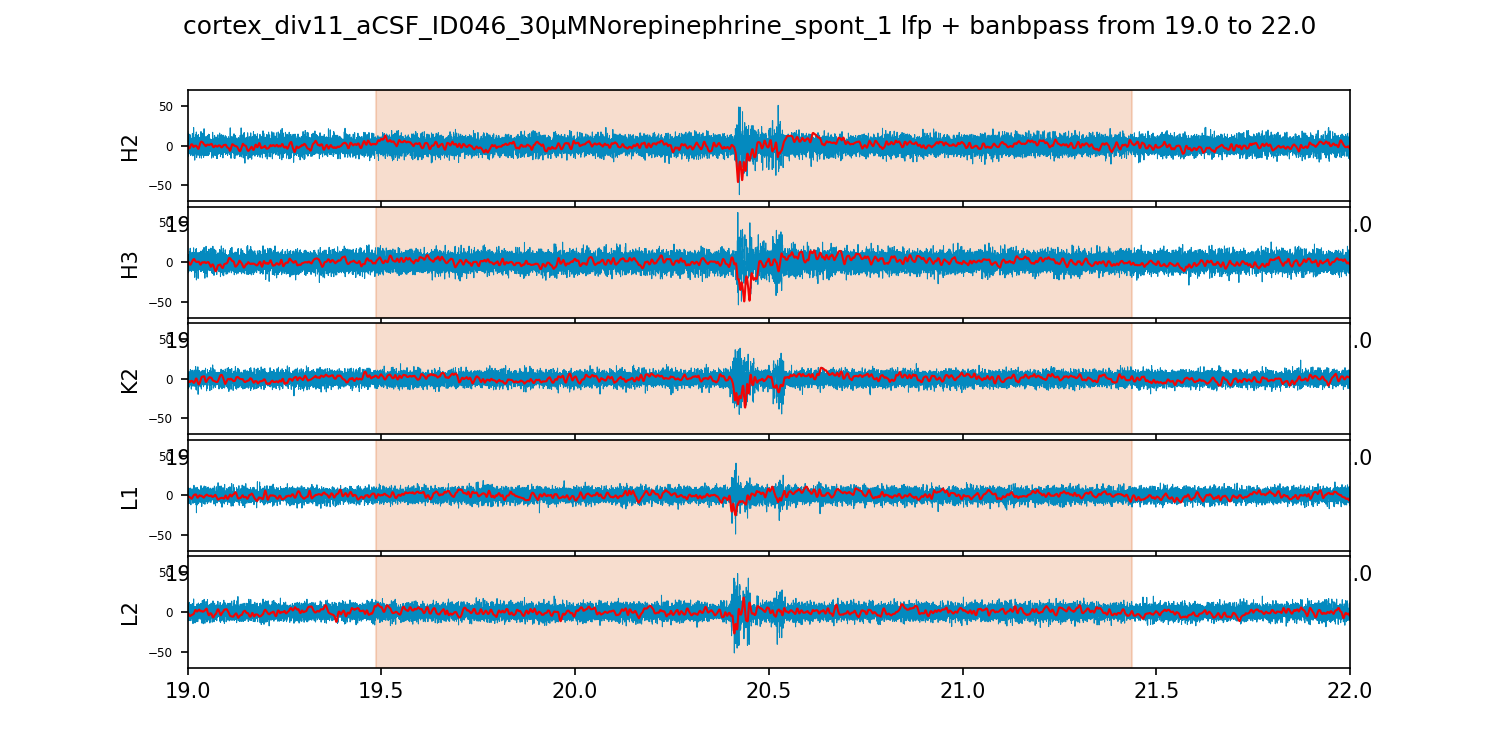

In [164]:
k = "(19.486669498338873, 21.437237182724253)"

nb_start = float(k.split("(")[1].split(")")[0].split(',')[0])
nb_stop = float(k.split("(")[1].split(")")[0].split(',')[1])

limit0, limit1 = np.round(nb_start), np.ceil(nb_stop) 


# netowrkburst of interest
nboi= network_bursts_dictionary[k]
bursting_channels = nboi['bursting_channels']
down_channels = list(network_bursts_dictionary[k]['channels_lfp_up'])
up_channels = list(network_bursts_dictionary[k]['channels_lfp_up'])
lfp_channels = up_channels + down_channels

channels_of_interest = list(bursting_channels)

channels_of_interest.sort()

number_traces = len(channels_of_interest)

fig = plt.figure(figsize=(10, number_traces))

gs1 = gridspec.GridSpec(number_traces, 1)
gs1.update(wspace=0.025, hspace=0.05) 
axs = []

for i in range(1, number_traces+1):
    
    
    key = channels_of_interest[i-1]
    
    #no get all signals to plot and the lfp_down and lfp_ups
    bandpass_signal = bandpass_dic[key]
    # in the lowpass_dic there are still additional returns from the old butter filter function
    lowpass_signal = lowpass_dic[key]
    ups = lfp_ups[key]
    downs = lfp_downs[key]
    
    
    
    axs.append(fig.add_subplot(gs1[i-1]))
    
    
    axs[-1] = plt.plot(time_in_sec, bandpass_signal, c="#048ABF", linewidth = 0.5)
    axs[-1] = plt.plot(time_in_sec, lowpass_signal, c='#F20505', linewidth=1)
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    #ax.get_xaxis().set_visible(False)
    frameon = False
    
    ax = plt.axvspan(nb_start, nb_stop, color='#D9580D', alpha=0.2)
    
    for i in downs:
        ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
    for i in ups:
        ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)
        
    

    # plt xlim for zooming in the time
    plt.xlim(limit0, limit1)
    plt.ylim(-70, 70)
    plt.yticks(fontsize='xx-small')
    plt.ylabel(key)
    
    fig.suptitle(filebase + ' lfp + banbpass from '+str(limit0)+' to '+str(limit1))

In [74]:
def plot_networkburst_traces(network_bursts_dictionary):
    
    
    for burst in network_bursts_dictionary:
        plt.ioff()
        k = burst

        nb_start = float(k.split("(")[1].split(")")[0].split(',')[0])
        nb_stop = float(k.split("(")[1].split(")")[0].split(',')[1])

        limit0, limit1 = np.around(nb_start-0.5, decimals=2), np.around(nb_stop+0.5, decimals=2)


        # netowrkburst of interest
        nboi= network_bursts_dictionary[k]
        bursting_channels = nboi['bursting_channels']
        active_channels = nboi['active_channels']
        down_channels = list(network_bursts_dictionary[k]['channels_lfp_up'])
        up_channels = list(network_bursts_dictionary[k]['channels_lfp_up'])
        lfp_channels = up_channels + down_channels
        
   
        channels_of_interest = list(active_channels)

        channels_of_interest.sort()

        number_traces = len(channels_of_interest)

        fig = plt.figure(figsize=(10, number_traces))

        gs1 = gridspec.GridSpec(number_traces, 1)
        gs1.update(wspace=0.025, hspace=0.05) 
        axs = []

        for i in range(1, number_traces+1):


            key = channels_of_interest[i-1]

            #no get all signals to plot and the lfp_down and lfp_ups
            bandpass_signal = bandpass_dic[key]
            # in the lowpass_dic there are still additional returns from the old butter filter function
            lowpass_signal = lowpass_dic[key]
            ups = lfp_ups[key]
            downs = lfp_downs[key]



            axs.append(fig.add_subplot(gs1[i-1]))


            axs[-1] = plt.plot(time_in_sec, bandpass_signal, c="#048ABF", linewidth = 0.5)
            axs[-1] = plt.plot(time_in_sec, lowpass_signal, c='#F20505', linewidth=1)
            #ax.spines['top'].set_visible(False)
            #ax.spines['right'].set_visible(False)
            #ax.spines['bottom'].set_visible(False)
            #ax.spines['left'].set_visible(False)
            #ax.get_xaxis().set_visible(False)
            frameon = False

            ax = plt.axvspan(nb_start, nb_stop, color='#C1D96C', alpha=0.1)

            for i in downs:
                ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
            for i in ups:
                ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)



            # plt xlim for zooming in the time
            plt.xlim(limit0, limit1)
            plt.ylim(-70, 70)
            plt.yticks(fontsize='xx-small')
            plt.ylabel(key)

        fig.suptitle(filebase + ' network burst from '+str(limit0)+' to '+str(limit1))

        fig.savefig(
        filebase + '_lfp_and_bandpasssignal_cutout_from_' + str(limit0) +'_to_'+str(limit1)+'.png',
        bbox_inches='tight', dpi=300)
        plt.close()


In [95]:
os.chdir(output_directory)

In [96]:
plt.ioff()

In [90]:
plot_networkburst_traces(network_bursts_dictionary, interest_channels = 'bursting')

ValueError: Image size of 3000x75300 pixels is too large. It must be less than 2^16 in each direction.

In [178]:
network_bursts_dictionary[k]

{'bursting_channels': array(['H2', 'H3', 'K2', 'L1', 'L2'], dtype='<U2'),
 'number_of_bursting_channels': 5,
 'number_burst_starts': 5,
 'number_burst_ends': 5,
 'active_channels': array(['F2', 'G2', 'H1', 'H2', 'H3', 'J1', 'J2', 'J3', 'K2', 'K3', 'K4',
        'L1', 'L2', 'L5'], dtype='<U2'),
 'number_of_active_channels': 14,
 'number_of_spikes': 66,
 'channels_lfp_up': array([], dtype=float64),
 'number_channels_with_lfp_up': 0,
 'mean_up_lfp_amplitude': nan,
 'channels_lfp_down': array([], dtype=float64),
 'number_channels_with_lfp_down': 0,
 'mean_down_lfp_amplitude': nan,
 'n_layer1_channels': 0,
 'n_layer2-3_channels': 44,
 'n_layer4_channels': 13,
 'n_layer5-6_channels': 0,
 'n_whitematter_channels': 0}

In [70]:
lfd = {}



In [71]:
len(lfd)

0

In [72]:
lfd['G12']=[]


In [73]:
len(lfd)


1